<a href="https://colab.research.google.com/github/thekaranacharya/nlp-poetry-generation/blob/master/irish_poetry_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Automatically generate Irish poetry using Deep Learning**

Import the libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
print(tf.__version__)

2.3.0


Download the dataset

In [2]:
import os
dataset_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt"
filename = os.path.join(os.getcwd(), "irish-lyrics.txt")
tf.keras.utils.get_file(filename, origin=dataset_url)

73728/68970 [================================] - 0s 0us/step


'/content/irish-lyrics.txt'

Read the contents of the dataset and add to corpus

In [34]:
corpus = []
with open(filename, 'r') as f:
    for line in f:
        line = line.replace("\n", "")
        corpus.append(line)

corpus[: 10]

['Come all ye maidens young and fair',
 'And you that are blooming in your prime',
 'Always beware and keep your garden fair',
 'Let no man steal away your thyme',
 'For thyme it is a precious thing',
 'And thyme brings all things to my mind',
 'nlyme with all its flavours, along with all its joys',
 'Thyme, brings all things to my mind',
 'Once I and a bunch of thyme',
 'i thought it never would decay']

In [38]:
import itertools
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
vocab_size = len(word_index)

print("Word Index Items (first 10) :\n", dict(itertools.islice(word_index.items(), 10)))
print("\n Vocab Size : ", vocab_size)

Word Index Items (first 10) :
 {'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10}

 Vocab Size :  2689


Convert all text to corresponding tokens and generate all combinations of inputs

In [39]:
input_sequences = []
sequences = tokenizer.texts_to_sequences(corpus)

for sequence in sequences:
    for i in range(1, len(sequence)):
        n_gram = sequence[: i + 1]
        input_sequences.append(n_gram)

input_sequences[: 10]

[[51, 12],
 [51, 12, 96],
 [51, 12, 96, 1217],
 [51, 12, 96, 1217, 48],
 [51, 12, 96, 1217, 48, 2],
 [51, 12, 96, 1217, 48, 2, 69],
 [2, 11],
 [2, 11, 15],
 [2, 11, 15, 31],
 [2, 11, 15, 31, 361]]

Pad the input sequences and get x & y

In [41]:
MAX_LENGTH = max(len(n_gram) for n_gram in input_sequences)
padded = pad_sequences(input_sequences, maxlen=MAX_LENGTH, padding='pre')


x, labels = padded[:, : -1], padded[:, -1]

# one-hot encode the labels
y = tf.keras.utils.to_categorical(labels, num_classes=vocab_size + 1)

Define the model

In [21]:
model = Sequential([
    Embedding(input_dim=vocab_size + 1, output_dim=128, input_length=MAX_LENGTH - 1),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(100, 'relu'),
    Dense(vocab_size + 1, 'softmax')
])

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 15, 128)           344320    
_________________________________________________________________
lstm_7 (LSTM)                (None, 15, 128)           131584    
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_8 (Dense)              (None, 2690)              271690    
Total params: 803,502
Trainable params: 803,502
Non-trainable params: 0
_________________________________________________________________


Fit

In [22]:
history = model.fit(x, y, epochs=300)

Epoch 1/300
377/377 [==============================] - 7s 19ms/step - loss: 6.7724 - accuracy: 0.0629
Epoch 2/300
377/377 [==============================] - 7s 19ms/step - loss: 6.2888 - accuracy: 0.0668
Epoch 3/300
377/377 [==============================] - 7s 18ms/step - loss: 6.0807 - accuracy: 0.0754
Epoch 4/300
377/377 [==============================] - 7s 18ms/step - loss: 5.9310 - accuracy: 0.0787
Epoch 5/300
377/377 [==============================] - 7s 18ms/step - loss: 5.7907 - accuracy: 0.0871
Epoch 6/300
377/377 [==============================] - 7s 18ms/step - loss: 5.6603 - accuracy: 0.0921
Epoch 7/300
377/377 [==============================] - 7s 18ms/step - loss: 5.5376 - accuracy: 0.1002
Epoch 8/300
377/377 [==============================] - 7s 18ms/step - loss: 5.4216 - accuracy: 0.1048
Epoch 9/300
377/377 [==============================] - 7s 18ms/step - loss: 5.3229 - accuracy: 0.1103
Epoch 10/300
377/377 [==============================] - 7s 18ms/step - loss: 5.227

Plot the accuracy & loss graph

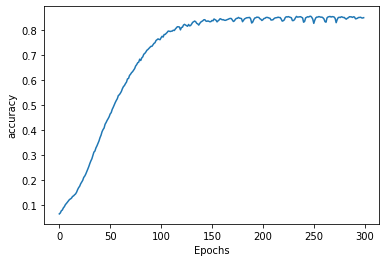

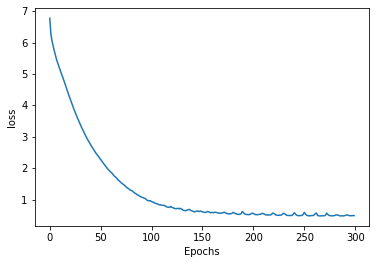

In [23]:
import matplotlib.pyplot as plt
def plot_graphs(val):
    plt.plot(history.history[val])
    plt.xlabel('Epochs')
    plt.ylabel(val)
    plt.show()

plot_graphs('accuracy')
plot_graphs('loss')

Predict!

In [42]:
import random
seed_text = 'Then came a sailor'
next_words = 100

for _ in range(next_words):
    sequence = tokenizer.texts_to_sequences([seed_text])[0]
    padded = pad_sequences([sequence], maxlen=MAX_LENGTH - 1, padding='pre')
    predicted = model.predict_classes(padded)
    output_word = ''

    for word, index in word_index.items():
        if index == predicted:
            output_word = word
            break

    seed_text += f' {output_word}'

# print in the format of a poetry
words = seed_text.split(" ")
text = ""
count = 0
for word in words:
  count += 1
  r = random.randint(8, 16)
  if count >= r :
    count = 0
    text += f' {word} \n'
  else:
    text += f' {word}'

print(text)

 Then came a sailor a the truth in 
 peace ned melting snow with feet corporal casey to love so runaway and saw 
 their rent and those wailing desolation mcbryde be your eyes fell 
 behind behind his right ray that loud to great why i spent 
 gone to wines of tralee an pretty rose are on 
 their wheel thats my comb mary lamenting say your neatest love apron 
 are they and you did her the truth in erin go 
 nor and red far and stainless then i puff whiskey and low can 
 look as i home kept old hall seen loch brown of 
 this more


And that's it! This is a poetry generated by your Deep Learning NLP model based on the Irish poetry dataset from Laurence Moroney.

The model has been fine-tuned previously so as not to have repetitions.

I have deliberately not used a Bidirectional LSTM as we're always predicting the next word.